In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)

import pandas as pd
import geopandas as gpd

import dask.dataframe as dd

from segment_speed_utils import helpers
from segment_speed_utils.project_vars import SEGMENT_GCS, analysis_date
from shared_utils.rt_utils import arrowize_segment
from shared_utils import gtfs_utils_v2
from calitp_data_analysis import geography_utils, utils
from calitp_data_analysis.tables import tbls


import numpy as np
import shapely
from siuba import *

# Add interpolated segments to pipeline

* Additional detail between widely spaced stops is more useful for speed analysis

## Check existing segments

In [2]:
segs_path = 'gs://calitp-analytics-data/data-analyses/rt_segment_speeds/segment_options/stop_segments_2024-03-13.parquet'
GCS_PATH = 'gs://calitp-analytics-data/data-analyses/rt_segment_speeds/segment_options/'

In [3]:
# read via geopandas so that geometry stays intact
segs = gpd.read_parquet(segs_path)

In [4]:
# segs >> head(3)

##  Less than 6% of segments need to be interpolated...


In [5]:
segs.length.quantile(.94)

997.6817468833709

# Additional Columns Required

Should probably happen upstream in `cut_stop_segments.py`, related scripts...

* `length`: float, `geometry.length`
* `next_stop_sequence`: lead of `stop_sequence`, should include final stop seq (final stop seq unavailable here since shifting from existing df...)
    * alternatively, rename `stop_sequence` -> `stop_sequence1` and add `stop_sequence2` (consistent with existing `stop_id1` and `stop_id2`)

## Adding these after the fact for testing...

In [6]:
# segs_ddf = dd.from_pandas(segs, npartitions=50)

# segs_ddf = segs_ddf.assign(length=lambda x: x.geometry.length)

# next_sequence_ddf = segs_ddf[['trip_instance_key', 'stop_sequence']].groupby('trip_instance_key').shift(-1)
# next_sequence_ddf = next_sequence_ddf.rename(columns={'stop_sequence': 'next_stop_sequence'})

# #  note this relies on the index
# segs_ddf = segs_ddf.join(next_sequence_ddf)

# !mkdir test_segs

# segs_ddf[['next_stop_sequence', 'length']].to_parquet('test_segs/')

# # new_cols = segs_ddf.compute()

### restart kernel/seperate script

In [7]:
# segs_ddf = dd.read_parquet('test_segs/')

# segs_ddf

# segs = segs.join(segs_ddf.compute())

In [78]:
intermediate_file = 'test_interpolated_intermediate_2024-03-13.parquet'

In [81]:
utils.geoparquet_gcs_export(segs, GCS_PATH, intermediate_file)

In [82]:
segs = gpd.read_parquet(GCS_PATH+intermediate_file)

## Find BBBR10

In [9]:
bbb = gtfs_utils_v2.schedule_daily_feed_to_gtfs_dataset_name('2024-03-13') >> filter(_.name.str.contains('Big Blue'))

In [10]:
bbb

,key,date,feed_key,feed_timezone,base64_url,gtfs_dataset_key,gtfs_dataset_name,name,type,regional_feed_type
219,c35ae2a7cb1f9ad2cf0a5bce84ccf298,2024-03-13,4f9888472a8dad0f66bdbbd002312789,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,efbbd5293be71f7a5de0cf82b59febe1,Big Blue Bus Schedule,Big Blue Bus Schedule,schedule,None


In [11]:
str10 = tbls.mart_gtfs.dim_stop_times() >> filter(_.feed_key == '4f9888472a8dad0f66bdbbd002312789', _.trip_id == '919600') >> collect()

/opt/conda/lib/python3.9/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'arrival_time_interval'
  sqlalchemy.util.warn(
/opt/conda/lib/python3.9/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'departure_time_interval'
  sqlalchemy.util.warn(
/opt/conda/lib/python3.9/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'start_pickup_drop_off_window_interval'
  sqlalchemy.util.warn(
/opt/conda/lib/python3.9/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'end_pickup_drop_off_window_interval'
  sqlalchemy.util.warn(


In [12]:
# segs >> filter(_.trip_instance_key == 'd98e5cc1fb62e6e5ed0030934ef8a396') >> arrange(_.stop_sequence)

In [13]:
str10 >> select(_.trip_id, _.stop_id, _.stop_sequence, _.arrival_time, _.departure_time) >> arrange(_.stop_sequence) >> head (3)

,trip_id,stop_id,stop_sequence,arrival_time,departure_time
0,919600,1708,1,06:00:00,06:00:00
1,919600,227,2,06:01:00,06:01:00
2,919600,5,3,06:01:29,06:01:29


In [14]:
bbbr10 = (tbls.mart_gtfs.fct_scheduled_trips()
 >> filter(_.gtfs_dataset_key.isin(bbb.gtfs_dataset_key),
          _.route_short_name.str.contains('R10'),
          _.service_date == '2024-03-13')
) >> collect()

In [15]:
# bbbr10

In [16]:
# bbbr10.trip_id

## Work out function

In [17]:
test = segs >> filter(_.trip_instance_key == '3505bf6a20e8d29e83e545784a421bc7')

In [18]:
long = test >> filter(_.stop_sequence == 18)

In [19]:
geom = long.geometry.iloc[0]

In [20]:
geom.length

17696.81706739369

In [21]:
def split_distance(geom, dist=1000):
    '''
    geom: shapely.LineString
    
    returns a shapely.MultiLineString split every dist (meters)
    '''
    
    split_segs = geom.length // dist
    substrings = []
    for i in range(0, int(split_segs)):
        substrings += [shapely.ops.substring(geom, i * dist, (i+1) * dist)]
    substrings += [shapely.ops.substring(geom, split_segs * dist, geom.length)]
    new_geom = shapely.MultiLineString(substrings)
    
    return new_geom

In [22]:
new_geom = split_distance(geom)

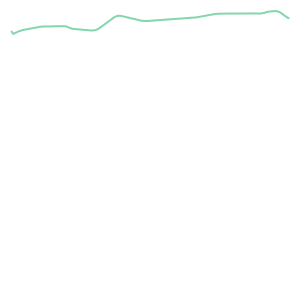

In [23]:
geom

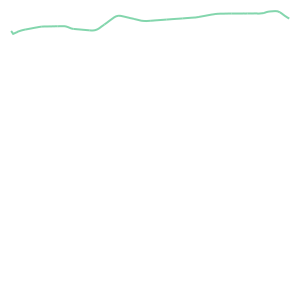

In [24]:
new_geom

In [25]:
# geom.wkt

In [26]:
# new_geom.wkt

In [27]:
long.geometry = [new_geom]

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [28]:
exploded = long.explode()

/tmp/ipykernel_445/1845589243.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = long.explode()


In [29]:
#  note order remains from list order passed to MultiLineString constructor
exploded.head(2)

trip_instance_key                   shape_array_key  \
2875405 0  3505bf6a20e8d29e83e545784a421bc7  37468c4ffbbbab83f270b8fcecb6de61   
        1  3505bf6a20e8d29e83e545784a421bc7  37468c4ffbbbab83f270b8fcecb6de61   

          stop_id1  stop_sequence stop_id2 segment_id stop_pair  \
2875405 0      228             18      106  228-106-1  228__106   
        1      228             18      106  228-106-1  228__106   

                  schedule_gtfs_dataset_key route_id  direction_id  \
2875405 0  efbbd5293be71f7a5de0cf82b59febe1     3714           0.0   
        1  efbbd5293be71f7a5de0cf82b59febe1     3714           0.0   

           next_stop_sequence        length  \
2875405 0                19.0  17696.817067   
        1                19.0  17696.817067   

                                                    geometry  
2875405 0  LINESTRING (143107.958 -441727.430, 143118.407...  
        1  LINESTRING (143967.823 -441640.058, 144006.108...

In [30]:
def process_exploded(gdf):
    '''
    update required cols in exploded gdf
    
    stop_sequence: increment proportional to segment distance within arbitrary stop sequence increment
    segment_id: postfix _(int) per segment to maintain uniqueness
    '''
    assert len(gdf.trip_instance_key.unique()) == 1 and len(gdf.segment_id.unique()) == 1, 'must group by trip_instance_key, segment_id'
    
    prev_stop = int(gdf.stop_sequence.min())
    next_stop = int(gdf.next_stop_sequence.max())
    stop_seq_chg = gdf.next_stop_sequence.max() - prev_stop
    
    #  increment stop sequence proportional to distance traveled 
    seq_per_km = stop_seq_chg / gdf.length.sum() 
    seq_changes = gdf.length * seq_per_km
    stop_sequences_scaled = np.flip(next_stop - np.flip(seq_changes).cumsum())
    
    gdf['stop_sequence'] = stop_sequences_scaled
    
    #  postfix to segment_id so that it remains unique
    postfixes = np.arange(0, gdf.shape[0]).astype(str)
    underscores = np.full(gdf.shape[0], '_')
    postfixes = np.char.add(underscores, postfixes)
    gdf['segment_id'] = gdf.segment_id + postfixes
    
    return gdf

In [31]:
processed = process_exploded(exploded)

In [32]:
arrowize_segment?

Signature: arrowize_segment(line_geometry, buffer_distance: int = 20)
Docstring:
Given a linestring segment from a gtfs shape,
buffer and clip to show direction of progression
File:      ~/data-analyses/_shared_utils/shared_utils/rt_utils.py
Type:      function

In [33]:
processed.geometry = processed.geometry.apply(lambda x: arrowize_segment(x))

In [34]:
processed.head(3)

trip_instance_key                   shape_array_key  \
2875405 0  3505bf6a20e8d29e83e545784a421bc7  37468c4ffbbbab83f270b8fcecb6de61   
        1  3505bf6a20e8d29e83e545784a421bc7  37468c4ffbbbab83f270b8fcecb6de61   
        2  3505bf6a20e8d29e83e545784a421bc7  37468c4ffbbbab83f270b8fcecb6de61   

          stop_id1  stop_sequence stop_id2   segment_id stop_pair  \
2875405 0      228      18.000000      106  228-106-1_0  228__106   
        1      228      18.056507      106  228-106-1_1  228__106   
        2      228      18.113015      106  228-106-1_2  228__106   

                  schedule_gtfs_dataset_key route_id  direction_id  \
2875405 0  efbbd5293be71f7a5de0cf82b59febe1     3714           0.0   
        1  efbbd5293be71f7a5de0cf82b59febe1     3714           0.0   
        2  efbbd5293be71f7a5de0cf82b59febe1     3714           0.0   

           next_stop_sequence        length  \
2875405 0                19.0  17696.817067   
        1                19.0  17696.817067   
        2                19.0  17696.817067   

                                                    geometry  
2875405 0  POLYGON ((143475.239 -441774.715, 143514.754 -...  
        1  POLYGON ((144774.726 -441469.401, 144927.328 -...  
        2  POLYGON ((145112.933 -441431.350, 145928.926 -...

In [35]:
# processed.explore()

# Abstracting (to move to new script?)

* seperate short and long segments
* split long segments and update columns to preserve unique segment_id, meaningful stop_sequence that is sortable and proportional to distance travelled (when between actual stops, no proportionality requirement in original feed)
* recombine

In [36]:
shorts = (segs[segs['length'] < 1000]).copy()

In [37]:
longs = (segs[segs['length'] > 1000]).copy()

In [38]:
longs = longs >> filter(-_.next_stop_sequence.isna()) #  fix upstream (include final next seq...)

In [39]:
longs.shape

(163577, 13)

In [40]:
test_longs = longs.iloc[:1000,:]

In [41]:
test_longs.head(3)

,trip_instance_key,shape_array_key,stop_id1,stop_sequence,geometry,stop_id2,segment_id,stop_pair,schedule_gtfs_dataset_key,route_id,direction_id,next_stop_sequence,length
22,0000dbb743b258f707687f2dc14ad90f,37bb198ccd3af93e3b7f10bb7602faff,819,1672,"LINESTRING (195533.932 -435807.899, 195532.071...",2304,819-2304-1,819__2304,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,1959.0,1734.469963
78,09e32488392ad4c1684b0108f3bba8b3,37bb198ccd3af93e3b7f10bb7602faff,819,1532,"LINESTRING (195533.932 -435807.899, 195532.071...",2304,819-2304-1,819__2304,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,1767.0,1734.469963
134,0aaeb33101f4ac9ebb7851388c355825,37bb198ccd3af93e3b7f10bb7602faff,819,1672,"LINESTRING (195533.932 -435807.899, 195532.071...",2304,819-2304-1,819__2304,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,1959.0,1734.469963


## Rowwise apply and accumulate? (works but too slow, ~45min)

In [42]:
# def interpolate_segments(row):
#     '''
#     wrapper function -- rowwise apply to a gdf of "long" (>1000m) segments
#     '''
#     global interpolated_longs
#     new_geom = split_distance(row.geometry)

#     row.geometry = new_geom
#     #  back to gdf to use .explode()
#     row = (gpd.GeoDataFrame(row)
#            .transpose()
#            .set_geometry('geometry')
#            .set_crs(geography_utils.CA_NAD83Albers)
#           )
#     exploded = gpd.GeoDataFrame.explode(row, column='geometry', index_parts=False)
#     # return exploded
#     processed = process_exploded(exploded)
    
#     interpolated_longs += [processed]
#     return

In [43]:
# test1 = test_longs.head(1)

# x = test1.apply(interpolate_segments, axis=1)

# gdf = pd.concat(interpolated_longs)

# #  can't split at endpoints (no next stop seq, must calculate upstream instead of shift!)
# #  drop for now to test
# test_longs = test_longs >> filter(-_.next_stop_sequence.isna())

# %%timeit

# interpolated_longs = []

# _ = test_longs.apply(interpolate_segments, axis=1)

# (14 * 177) / 60 #  41min to interpolate all -- not entirely ideal

# (interpolated >> distinct(_.segment_id, _keep_all=True)).shape

In [44]:
# interpolated = pd.concat(interpolated_longs)

## Compute new geometries only once

* compute/join on `shape_array_key, segment_id`
* accumulate geoms only in dict based on unique df; lookup/replace geoms in full df, then use `gdf.explode()`, `process_exploded`
* ~12min total for entire state, could maybe speed up `process_exploded` since it's a groupby/apply but this implementation depends on the gdf staying in order for each trip/segment after `explode`

In [45]:
longs.head(1)

,trip_instance_key,shape_array_key,stop_id1,stop_sequence,geometry,stop_id2,segment_id,stop_pair,schedule_gtfs_dataset_key,route_id,direction_id,next_stop_sequence,length
22,0000dbb743b258f707687f2dc14ad90f,37bb198ccd3af93e3b7f10bb7602faff,819,1672,"LINESTRING (195533.932 -435807.899, 195532.071...",2304,819-2304-1,819__2304,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,1959.0,1734.469963


In [46]:
#  segments missing from interpolation because we're missing the last stop sequence in testing
#  should be fixed in prod!

# (longs >> distinct(_.shape_array_key, _.segment_id, _keep_all=True)
#                      >> filter(_.next_stop_sequence.isna())).explore()

In [47]:
def store_new_geoms(row):
    '''
    wrapper function -- rowwise apply to a gdf of "long" (>1000m) segments
    
    accumulate results in a dict: segment_geoms (init empty dict outside function)
    '''
    global segment_geoms
    new_geom = split_distance(row.geometry)
    # row.geometry = new_geom
    
    geom_key = (row.shape_array_key, row.segment_id)
    segment_geoms[geom_key] = new_geom
    #  TODO store key:geom in dict/something fast...
    
    return

In [48]:
def lookup_geom(row, segment_geoms: dict):
    '''
    after running store_new_geoms on unique segments, apply this to 
    a gdf of all segments to lookup new geom by shape_array_key, segment_id
    '''
    row.geometry = segment_geoms[(row.shape_array_key, row.segment_id)]
    return row

In [49]:
to_interpolate = (longs >> distinct(_.shape_array_key, _.segment_id, _keep_all=True)
                 )

In [50]:
to_interpolate >> head(1)

,trip_instance_key,shape_array_key,stop_id1,stop_sequence,geometry,stop_id2,segment_id,stop_pair,schedule_gtfs_dataset_key,route_id,direction_id,next_stop_sequence,length
0,0000dbb743b258f707687f2dc14ad90f,37bb198ccd3af93e3b7f10bb7602faff,819,1672,"LINESTRING (195533.932 -435807.899, 195532.071...",2304,819-2304-1,819__2304,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,1959.0,1734.469963


In [51]:
%%time

segment_geoms = {}

_ = to_interpolate.apply(store_new_geoms, axis=1)

CPU times: user 25.4 s, sys: 88 ms, total: 25.5 s
Wall time: 26.9 s


In [52]:
%%time
#  now, add geometries to long list...
interpolated = longs.apply(lookup_geom, axis = 1, args = ([segment_geoms]))

CPU times: user 22.9 s, sys: 536 ms, total: 23.4 s
Wall time: 25 s


In [53]:
interpolated = interpolated.explode(index_parts=False).reset_index(drop=True)

In [54]:
interpolated['length'] = interpolated.geometry.apply(lambda x: x.length)

In [55]:
interpolated.shape

(514674, 13)

### Parallel (runs, but slower than single-thread for this task anyway. Also, still have some ordering issues.)

https://docs.dask.org/en/stable/generated/dask.dataframe.groupby.DataFrameGroupBy.apply.html
* "If the grouper does not align with the index then this causes a full shuffle. The order of rows within each group may not be preserved."
* attempted to set index equal to grouper, but some segments still seem to end up out of order...

In [56]:
# interpolated = interpolated.set_index(['trip_instance_key', 'segment_id'], drop=False)
# #  dask doesn't support MultiIndex...

# interpolated = interpolated.set_index(pd.util.hash_pandas_object(interpolated.index))

# interpolated.index.name = 'trip_seg_hash'

# int_meta = dd.utils.make_meta(interpolated)

# # interpolated.info()

# int_dd = dd.from_pandas(interpolated, npartitions=20)

# int_group = int_dd.groupby(by='trip_seg_hash')

# int_group = int_group.apply(process_exploded, meta = int_meta)

# %%time
# #  13min -- actually slower than Pandas in this case
# result = int_group.compute()

### Single-thread (works, about 10min)

* depends on df remaining in order from .explode()

In [57]:
# %%time

# processed = interpolated.groupby(['trip_instance_key', 'segment_id'], group_keys=False).apply(process_exploded)

# recombined = pd.concat([shorts, processed]).reset_index(drop=True)

# utils.geoparquet_gcs_export(recombined, gcs_file_path=GCS_PATH, file_name=filename)

In [58]:
filename = 'test_interpolated_2024-03-13.parquet'

In [59]:
recombined = gpd.read_parquet(GCS_PATH+filename)

In [60]:
interpolated.shape

(514674, 13)

In [61]:
interpolated.shape[0] + shorts.shape[0]

3318446

In [62]:
recombined.shape #  looks OK

(3318446, 13)

# Taking a look: Big Blue Bus R10

* split and merge with untouched segments looks good!

In [63]:
from siuba import * #  re-import to fix bug? TODO report...

In [64]:
test = recombined[recombined.trip_instance_key == '3505bf6a20e8d29e83e545784a421bc7']

In [65]:
test.geometry = test.geometry.apply(lambda x: arrowize_segment(x))

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [66]:
# test.explore()

# Further Testing: Salinas Valley, Woodland/Davis/Sac, Bay Br, I110 (Harbor Fwy), etc. all look good!

In [67]:
bigtest = (recombined >> distinct(_.segment_id, _.shape_array_key, _keep_all=True))

In [68]:
bigtest.shape

(203106, 13)

In [69]:
bigtest = bigtest >> filter(_.shape_array_key.isin(_.shape_array_key.unique()[:250]))

In [70]:
bigtest.geometry = bigtest.geometry.apply(lambda x: arrowize_segment(x))

In [71]:
bigtest.shape

(11034, 13)

In [76]:
# bigtest.explore()